In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 12, 8

# Data

In [11]:
seed = 3141592653

N_PACKAGES = 60 # note here we are using double the amount of packages than in the previous tutorial

MIN_WEIGHT = 0.1
MAX_WEIGHT = 10

MIN_VALUE = 0.1
MAX_VALUE = 100
# ---------------

np.random.seed(seed)

weights = np.abs(np.random.normal(MIN_WEIGHT, MAX_WEIGHT, N_PACKAGES))
values = np.abs(np.random.normal(MIN_VALUE, MAX_VALUE, N_PACKAGES))

In [12]:
packages = {idx: {'weight': weights[idx], 'value': values[idx]} for idx in range(N_PACKAGES)}

[package for ipackage, package in packages.items()][:4]

[{'weight': 16.045064716419265, 'value': 156.58886215858956},
 {'weight': 10.257933643337433, 'value': 104.62645511942335},
 {'weight': 7.427142915985984, 'value': 30.639490213482468},
 {'weight': 16.1061446548582, 'value': 15.263663729191537}]

Text(0.5, 1.0, 'Packages')

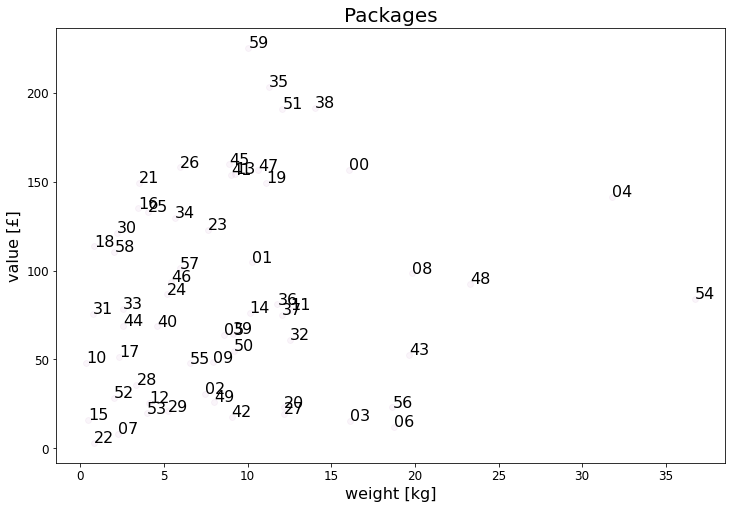

In [13]:
plt.scatter([packages[idx_package]['weight'] for idx_package in packages],
            [packages[idx_package]['value'] for idx_package in packages],
            color = 'purple', alpha=0.04
           )

for idx_package, package in packages.items():
    plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), fontsize=MEDIUM_SIZE)
    
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Packages')

# Scoping Challenge


**Combinations**.   

An unordered arrangement of $k$ objects from a set of $n$ 
$$
_nC_k=\frac{n!}{(n-k)!k!}\equiv {n \choose k}
$$

Here we use     
`k = N_PACKAGES_PER_KNAPSACK`  
`n = N_PACKAGES`,  
with assumptions for siplicity:  
* A package can appear only once in a a knapsack.  
* The order of a package assigned to a knapsack does not matter.  


In [14]:
from math import factorial

# Defining the Decision Space

In [17]:
def pretty_int(x):
    if x > 1.e6:
        return f'{int(x):0.1e}'
    else:
        return f'{int(x):,}'

N_PACKAGES_PER_KNAPSACK = 30
# -----------
    
n = N_PACKAGES
k = N_PACKAGES_PER_KNAPSACK

n_combinations = factorial(n)/factorial(k)/factorial(n-k)

f'There are {pretty_int(n_combinations)} combinations of {n} choose {k}.'

'There are 1.2e+17 combinations of 60 choose 30.'

# Defining the Objective Space

In [18]:
objectives = ['weight', 'value']

In [19]:
def knapsack_objective(knapsack, objective, packages):
    knapsack[objective] = np.sum([packages[idx_package][objective] for idx_package in knapsack['packages']])
 

In [120]:
def create_knapsacks(n_knapsacks=1000, seed=0, n_packages=N_PACKAGES, n_packages_per_knapsack=N_PACKAGES_PER_KNAPSACK):
    knapsacks = {}
    for idx_knapsack in range(n_knapsacks):
        if seed:
            np.random.seed(idx_knapsack + seed)
        this_idxs_packages = np.random.choice(range(n_packages), n_packages_per_knapsack, replace=False)

        knapsacks[idx_knapsack] = {}
        knapsacks[idx_knapsack]['packages']= this_idxs_packages

        for objective in objectives:
            knapsack_objective(knapsacks[idx_knapsack], objective, packages)
            
    return knapsacks

In [46]:
n_instances = 4
n_knapsacks = 1000

knapsacks_instances = {}
for idx in range(n_instances):
    knapsacks_instances[idx] = create_knapsacks(n_knapsacks, seed=idx)



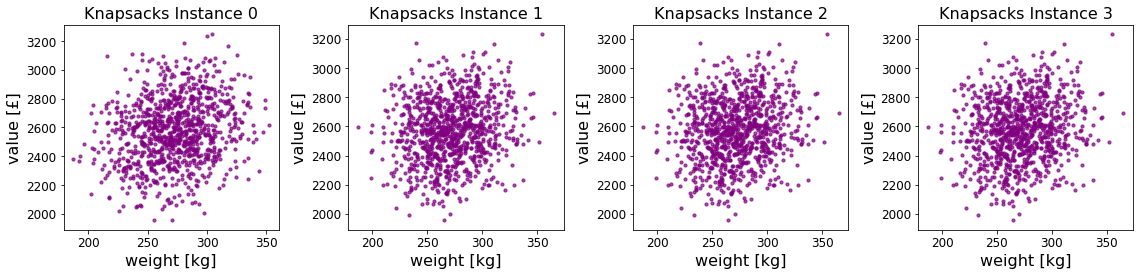

In [64]:
nplots = n_instances
ncols = 4
nrows = nplots // ncols + np.sum(nplots % ncols != 0)

plt.figure(figsize=(4 * ncols, 4 * nrows))

for idx_instance in knapsacks_instances:
    plt.subplot(nrows, ncols, idx_instance + 1)
    
    plt.scatter([knapsacks['weight'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                [knapsacks['value'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                s=10, alpha=0.7, color='purple')

    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    plt.title(f'Knapsacks Instance {idx_instance}', fontsize=MEDIUM_SIZE)
plt.tight_layout()

# Pareto Front Calculation

In [26]:
from operator import lt as less_than, gt as greater_than

In [30]:
mode_to_operator = {'min': greater_than, 'max': less_than}

objective_mode = {'weight': 'min', 'value': 'max'}

objective_operator = {key: mode_to_operator[objective_mode[key]] for key in objective_mode.keys()}
objective_operator

{'weight': <function _operator.gt(a, b, /)>,
 'value': <function _operator.lt(a, b, /)>}

In [84]:
def knapsacks_to_pareto_front(knapsacks):
    objective_values = {}

    for objective in objectives:
        objective_values[objective] = [knapsacks[idx][objective] for idx in knapsacks]
        
    idxs_pareto = []
    
    idx_objects = list(knapsacks.keys())

    for idx in range(len(objective_values[objective])):
        is_dominated = False

        this_weight = objective_values['weight'][idx]
        this_value = objective_values['value'][idx]

        other_weights = np.array(objective_values['weight'][:idx] + objective_values['weight'][idx + 1:])
        other_values = np.array(objective_values['value'][:idx] + objective_values['value'][idx + 1:])

        for jdx in range(len(other_weights)):
            bool_ = objective_operator['weight'](this_weight, other_weights[jdx]) & objective_operator['value'](this_value, other_values[jdx])   

            if bool_:
                is_dominated = True
                break

        if not is_dominated:
            idxs_pareto.append(idx_objects[idx])
            
    return idxs_pareto

In [85]:
#idxs_pareto = knapsacks_to_pareto_front(knapsacks)

pareto_instances = {}
for idx_instance in knapsacks_instances:
    pareto_instances[idx_instance] = knapsacks_to_pareto_front(knapsacks_instances[idx_instance])

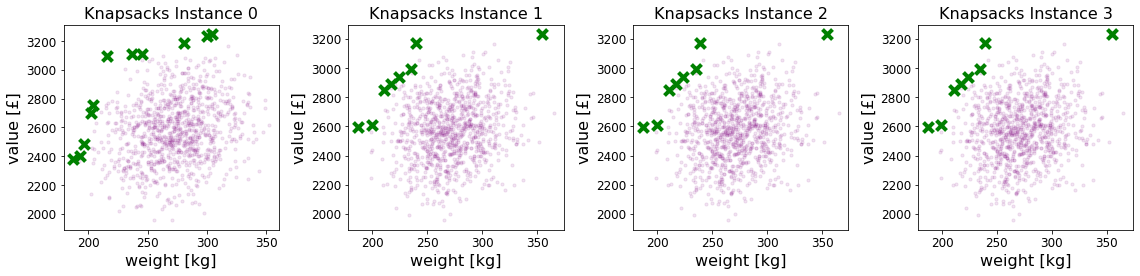

In [86]:
nplots = n_instances
ncols = 4
nrows = nplots // ncols + np.sum(nplots % ncols != 0)

plt.figure(figsize=(4 * ncols, 4 * nrows))

for idx_instance in knapsacks_instances:
    plt.subplot(nrows, ncols, idx_instance + 1)
    
    plt.scatter([knapsacks['weight'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                [knapsacks['value'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                s=10, alpha=0.1, color='purple')
    
    plt.scatter([knapsacks_instances[idx_instance][idx_knapsack]['weight'] for idx_knapsack in pareto_instances[idx_instance]], 
                [knapsacks_instances[idx_instance][idx_knapsack]['value'] for idx_knapsack in pareto_instances[idx_instance]], 
            marker='x', s=100, linewidth=4, color='green', label='Pareto Front')

    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    plt.title(f'Knapsacks Instance {idx_instance}', fontsize=MEDIUM_SIZE)
plt.tight_layout()

But this is clearly a subset of the full space that we calculated above.  

We would like a stochastic method to explore the space.

In [94]:
pareto_instances

knapsacks_pareto = {}
for idx_instance in knapsacks_instances:
    for idx_knapsack in pareto_instances[idx_instance]:
        idx_pareto = f'{idx_instance}-{idx_knapsack}'
        knapsacks_pareto[idx_pareto] = knapsacks_instances[idx_instance][idx_knapsack]


knapsacks_pareto_pareto = knapsacks_to_pareto_front(knapsacks_pareto)

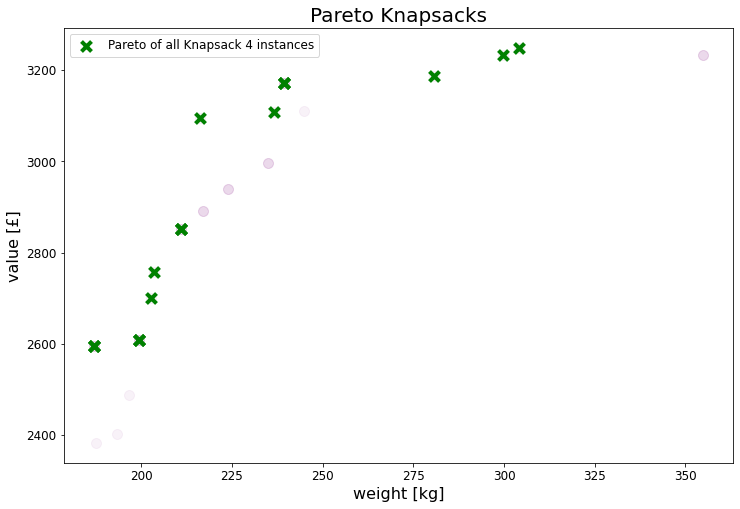

In [100]:
plt.scatter([knapsacks['weight'] for _, knapsacks in knapsacks_pareto.items()],
            [knapsacks['value'] for _, knapsacks in knapsacks_pareto.items()],
            s=100, alpha=0.05, color='purple')

plt.scatter([knapsacks_pareto[idx_knapsack]['weight'] for idx_knapsack in knapsacks_pareto_pareto], 
            [knapsacks_pareto[idx_knapsack]['value'] for idx_knapsack in knapsacks_pareto_pareto], 
        marker='x', s=100, linewidth=4, color='green', label=f'Pareto of all Knapsack {n_instances} instances')

plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title(f'Pareto Knapsacks')
plt.legend()

# Evolutionary Algorithm

In [187]:
N_INITIAL_POPULATION = 20
seed = 3141592653

population = create_knapsacks(N_INITIAL_POPULATION, seed=seed)

In [294]:
def cross_over_2_indvs(ind1, ind2):
    assert len(ind1) == len(ind2)
    
    mutuals = list(set(ind1) & set(ind2))
    
    #ind1_ = ind1.copy()
    #ind2_ = ind2.copy()
    
    non_overlap1 = [ind for ind in ind1 if ind not in mutuals]
    non_overlap2 = [ind for ind in ind2 if ind not in mutuals]
    
    ind1_ = non_overlap1.copy()
    ind2_ = non_overlap2.copy()
    
    n_ = len(ind1_)
    
    ind1_[n_//2:] = non_overlap2[n_//2:]
    ind2_[n_//2:] = non_overlap1[n_//2:]
    
    
    
    ind1_ += mutuals
    ind2_ += mutuals
    
    return ind1_, ind2_
    
cross_over_2_indvs(['A', 'B', 'C', 'D', 'E'], ['E', 2, 3, 4, 5])
#cross_over_2_indvs([1, 2, 3, 4, 5][::-1], [1, 2, 3, 4, 5])

#cross_over_2_indvs(knapsacks_plot['parent 1']['packages'], knapsacks_plot['parent 2']['packages'])

(['A', 'B', 4, 5, 'E'], [2, 3, 'C', 'D', 'E'])

In [295]:
def crossover_knapsacks(population, packages):
    n_population = len(population)
    
    idxs_parents = list(population.keys())
    
    idxs_parent2 = idxs_parents[1::2]
    idxs_parent1 = idxs_parents[::2][:len(idxs_parent2)]
    
    children = {}
    
    idx_child_counter = np.max(idxs_parents) # TODO: thie does not generalise well since indviduals will be dropped
    for idx_parent1, idx_parent2 in zip(idxs_parent1, idxs_parent2):
        #print(population[idx_parent1]['packages'])
        #print(population[idx_parent2]['packages'])
        #print('-' * 40)
        idx_child_counter += 1
        children[idx_child_counter] = {}
        children[idx_child_counter + 1] = {}
        
        children[idx_child_counter]['packages'], children[idx_child_counter + 1]['packages'] = cross_over_2_indvs(population[idx_parent1]['packages'], population[idx_parent2]['packages'])
        
        #for idx_child in children:
        #    for objective in objectives:
        #        children[idx_child]['objective'] = knapsack_objective(children[idx_child], objective, packages)
        
       
        idx_child_counter += 1
    
    return children
       
children = crossover_knapsacks(population, packages)

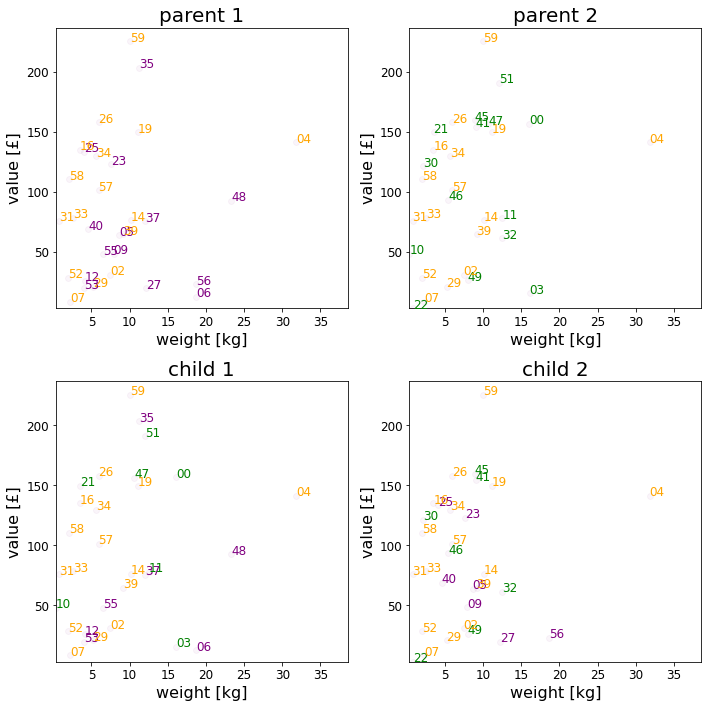

In [332]:
idx_parent1 = 4
assert idx_parent1 % 2 == 0
knapsacks_plot = {'parent 1': population[idx_parent1], 'parent 2': population[idx_parent1 + 1],
                  'child 1': children[min(list(children.keys())) + idx_parent1],
                  'child 2': children[min(list(children.keys())) + idx_parent1 + 1]
                 }

colors = {'parent 1': 'purple', 'parent 2': 'green', 'both': 'orange'}

# parents_packages = list(set(list(population[0]['packages']) + list(population[1]['packages'])))
# min_weight = np.min([packages[package]['weight'] for package in parents_packages])
# max_weight = np.max([packages[package]['weight'] for package in parents_packages])
# min_value = np.min([packages[package]['value'] for package in parents_packages])
# max_value = np.max([packages[package]['value'] for package in parents_packages])

min_weight = np.min([packages[package]['weight'] for package in packages])
max_weight = np.max([packages[package]['weight'] for package in packages])
min_value = np.min([packages[package]['value'] for package in packages])
max_value = np.max([packages[package]['value'] for package in packages])

ncols = 2
nrows = 2

plt.figure(figsize = (5 * ncols, 5 * nrows))

for ipanel, knapsack_idx in enumerate(knapsacks_plot):
    plt.subplot(nrows, ncols, ipanel + 1)
    
    idx_packages_in_knapsack = knapsacks_plot[knapsack_idx]['packages']
    
    plt.scatter([packages[idx_package]['weight'] for idx_package in idx_packages_in_knapsack],
                [packages[idx_package]['value'] for idx_package in idx_packages_in_knapsack],
                color = 'purple', alpha=0.04
               )
    
    #counts_ = {'both': 0, 'parent 1': 0, 'parent 2': 0}
    for idx_package in idx_packages_in_knapsack: 
        in_parent1 = idx_package in knapsacks_plot['parent 1']['packages']
        in_parent2 = idx_package in knapsacks_plot['parent 2']['packages']
        
        if in_parent1 & in_parent2:
            color = colors['both']
            #counts_['both'] += 1
        elif in_parent1:
            color = colors['parent 1']
            #counts_['parent 1'] += 1
        elif in_parent2:
            color = colors['parent 2']
            #counts_['parent 2'] += 1
        else:
            print('problem!')
            break
        
        plt.annotate(f'{idx_package:02.0f}', xy=(packages[idx_package]['weight'], packages[idx_package]['value']), alpha=1, color=color)
        
    #print(knapsack_idx, counts_)
    
    plt.title(knapsack_idx)
    
    plt.xlim(min_weight * 0.95, max_weight * 1.05)
    plt.ylim(min_value * 0.95, max_value * 1.05)
    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    
plt.tight_layout()

# The importance of Population

# Resources

## To consider 
* [stack overflow](https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python)
* `pymoo` ([site](http://pymoo.org/), [github](https://github.com/msu-coinlab/pymoo/tree/6bad624cc70d12856b47c17cf0f9908a1b3653c5), [arxiv](https://arxiv.org/pdf/2002.04504.pdf) ). comment: no spea2

# Decision Making

Role of domain expert. 

You might be that expert!  (annecdotal related video: The Expert)

Explore vs. Exploit